<a href="https://colab.research.google.com/github/sanvirrafsaan/Data-Science-Portfolio/blob/main/Churn-prediction/notebooks/01_ingest_and_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Business Context
Customer churn is a very expensive problem faced by subscription based businesses such as telecom providers, streaming services and other SaaS companies. When a customer cancels their service, we need to acquire another customer to keep our revenue numbers up, and there are additional costs to acquiring a new customer compared to retaining an existing one, which can lead to extra marketing or sales expenses. <br><br>
The goal of this project is to help businesses tackle this problem by identifying customers who are at high risk of leaving, before they actually cancel. <br><br>
To do this, my analysis focuses on 2 layers: <br>
##Understanding Churn Behavior <br>
- What characteristics differentiate customers who leave from the ones who stay?
- How long do customers typically stay subscribed before leaving?
- Which services, contract types or usage patterns correlate with higer risk?
##Predicting Churn Behavior
- After identifying the drivers of churn, a predictive model is built to flag at-risk customers. This enables the business to implement targeted retention strategies- Personalized offers, service improvements or outreach campaigns for example.

# Data Cleaning and feature Engineering
In this section, I will use the CLEAN framework for data cleaning. CLEAN:

- Conceptualize the data: What does each row represent? What are the main x and y variables?

- Locate solvable problems: Inconsistent data format, inconsistent categorizations, nulls, duplicates

- Evaluate unsolvable issues: Null values, outliers, business logic violation

- Augment the data: Slice and Dice by other time grains, add more dimensions for exploration, calculate new metrics

- Note the data: Take note of unsolvable problems

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

In [2]:
!git clone https://github.com/sanvirrafsaan/Data-Science-Portfolio.git
%cd Data-Science-Portfolio/Churn-prediction
!pip -q install -e .

fatal: destination path 'Data-Science-Portfolio' already exists and is not an empty directory.
/content/Data-Science-Portfolio/Churn-prediction
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for churn (pyproject.toml) ... done


In [3]:
from churn.paths import (
    RAW_DIR,
    INTERIM_DIR,
    ensure_dirs,
    debug_print,
)

ensure_dirs()
debug_print()


Mounted at /content/drive
Project root: /content/drive/MyDrive/Data Science Portfolio/churn-prediction
Raw data: [PosixPath('/content/drive/MyDrive/Data Science Portfolio/churn-prediction/data/raw/telco_churn.csv')]
Interim data: [PosixPath('/content/drive/MyDrive/Data Science Portfolio/churn-prediction/data/interim/interim_data.parquet')]


In [4]:
df = pd.read_csv(RAW_DIR / "telco_churn.csv")
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We see some inconsistencies in the column name data representation. Some observations incliude: ,
- We need to capitalize columnname "gender", "tenure", etc to follow the name format of the rest of the columns.
- Most Binary categorical columns are coded as "yes" and "no", bu the column SeionrCitizen has categories "0" and "1", with 0 representing no, 1 representing a yes. Format needs to be made consistent.

In [ ]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
df = df.rename(columns = {'gender': 'Gender', 'tenure': 'Tenure'})
df.head(5)

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Lets now check the types of columns we have, as well as statistical measures of both numeric and categoric columns.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
with pd.option_context(
    "display.max_columns", None,
    "display.precision", 2,
):
  display(df.describe())

,Tenure,MonthlyCharges
count,7043.00,7043.00
mean,32.37,64.76
std,24.56,30.09
min,0.00,18.25
25%,9.00,35.50
50%,29.00,70.35
75%,55.00,89.85
max,72.00,118.75


In [ ]:
df.describe(exclude="number")

,customerID,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


One problem we see here is that the TotalCharges column, a numeric column, is being picked up as non-numeric, and applying a categoric measure to that. So we need to investigate and ensure that df.describe() picks it up as a numeric column.

Let's look at the characteristics of the dataset as a whole. Most customers are:
- Male, but approximately 50-50 split.
-Younger than 65
- No partner or dependants
- Have Phone service with a single line and internet
- No online services or tech support
- No streaming services like tv, movies
- Have monthly contracts

In [ ]:
#try to convert to string, any values thatfails becomes na. Then puts original values in list
mask = pd.to_numeric(df['TotalCharges'], errors='coerce').isna()
string_values = df.loc[mask, 'TotalCharges'].tolist()
print(string_values)

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


As we can see, most of the problematic rows contain whitespace. Let's fix this.

In [ ]:
# replace the spaces with NaN (regex for single or multiple spaces)
df['TotalCharges'] = df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True)

#convert column to float
df['TotalCharges'] = df['TotalCharges'].astype(float)

Next, let's look for missing values.

In [ ]:
df.isna().sum()

customerID           0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Let's explore the 11 missing values in TotalCharges

In [ ]:
df[df['TotalCharges'].isna()]

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


These values are a very small percentage of our dataset so they can be removed. However, We see a pattern where these values represent new customers with a Tenure of 0. So we can take the Monthly charges and use it for the TotalCharges column.

In [ ]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])
df[df['Tenure'] == 0]

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,No
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,20.25,No
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,80.85,No
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,25.75,No
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,56.05,No
3331,7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,19.85,No
3826,3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,25.35,No
4380,2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,20.00,No
5218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,19.70,No
6670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,73.35,No


In [ ]:
df.describe()

,Tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.798992
std,24.559481,30.090047,2266.730170
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


We finally see the TotalCharges as a numeric column. Lastly, lets further conceptualize the data we have by looking at the proportion of classes.

In [ ]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [ ]:
df["Churn"].value_counts(normalize=True).mul(100).round(2)

Churn
No     73.46
Yes    26.54
Name: proportion, dtype: float64

We see that 73% of the customers did not churn, and there is a class imbalance. This is important to keep in mind later when selecting models and scores for testing. This is because most machine learning models optimize for accuracy, which the model can achieve in this case by simply selecting the majority class. For example, imagine a model predicting that every customer will not churn. It gets a 73.46% accuracy, but completely fail to identify customers who are leaving. <br>
From a business perspective, the customers who are at risk of leaving are the most important to predict, and we will need to account for that.

#Outlier Detection
Outliers are data points that are significantly different or extreme compared to most of the data. These can cause problems such as: <br>
- Distorting summary statistics such as the mean, median and variance
- Skew machine leanring models as they see these points as highly important. If they're noise, it can affect the performance of ML model
After detecting them, they can be investigated to see whether they stem from errors such as data entry errors, errors fetching the numbers or whether they represent rare customer profiles.

In [ ]:
numeric_features = df.select_dtypes(include="number").columns

target = "Churn"

id_column = "customerID"

categorical_features = df.select_dtypes(exclude="number").columns.drop(
    [target, id_column]
)
display(numeric_features)
display(categorical_features)


Index(['Tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [ ]:
def best_grid_shape(n):
    """Return (rows, cols) for a grid layout close to square."""
    rows = int(n**0.5)
    cols = rows
    if rows * cols < n:
        cols += 1
    if rows * cols < n:
        rows += 1
    return rows, cols

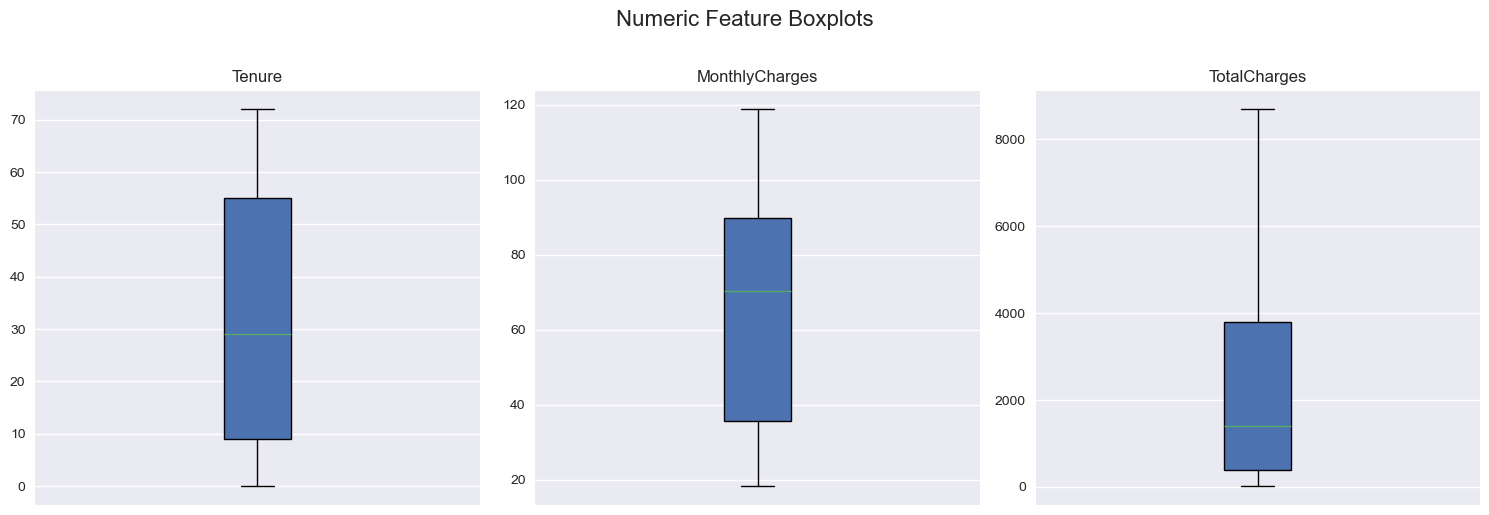

In [ ]:
import matplotlib.pyplot as plt

numeric_features = df.select_dtypes(include="number").columns

# optional: use a nicer built-in style
plt.style.use("seaborn-v0_8")   # or "ggplot"

n = len(numeric_features)
fig, axes = plt.subplots(1, n, figsize=(5*n, 5), tight_layout=True)


for ax, col in zip(axes, numeric_features):
    ax.boxplot(
        df[col].dropna(),
        vert=True,
        patch_artist=True  # fill the box
    )
    ax.set_title(col)
    ax.set_xticks([])      # remove the "1" on x-axis

fig.suptitle("Numeric Feature Boxplots", fontsize=16, y=1.02)
plt.show()

None of the numerical columns have outliers. However since we have a class imbalance, let's view the boxplots divided by each class.

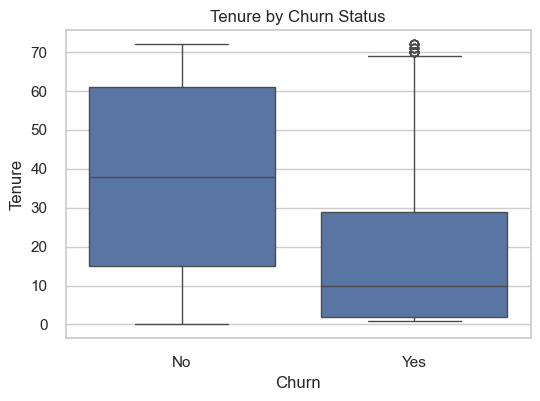

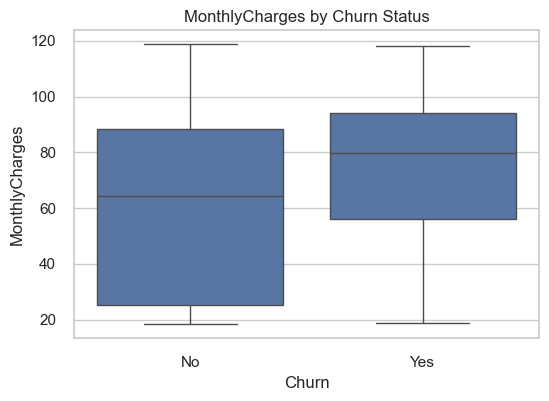

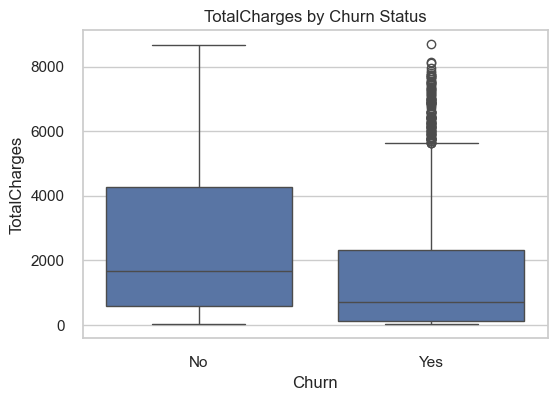

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

numeric_features = df.select_dtypes(include="number").columns

for feature in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x="Churn", y=feature)
    plt.title(f"{feature} by Churn Status")
    plt.show()

From the boxplot, we see:
- the median tenure for customers who have left is around 10 months, while it is around 40 months for those who have stayed with the company. So, customers who have churned spent less time with the company.
- the median monthly charge for customers who have churned is around 80, while it is around 65 for those who have not churned. Therefore, customers who have churned have higher monthly charges.
- since most customers who have churned spent less time with the company, they have low median total charges compared with those who have stayed
  - There are some outliers in the total charges boxplot of customers who have churned. This shows that some customers who have churned have high total charges, even though they have spent less time with the company. This could be due to high monthly charges. Since the data is consistent, we will keep these outliers.

##Categorical Columns
Next, we need to type the categorical columns as categories.

In [ ]:
df.columns[(df.nunique() == 2) & (df.dtypes != "category")]

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn'],
      dtype='object')

In [ ]:
for column in df.columns[(df.nunique() == 2) & (df.dtypes != "category")]:
    if column == "Gender":
        df[column] = pd.Categorical(
            df[column], categories=("Female", "Male"), ordered=False
        )
    else:
        df[column] = pd.Categorical(df[column], categories=("No", "Yes"), ordered=False)

In [ ]:
for column in df.columns[(df.nunique() <= 5) & (df.dtypes != "category")]:
    # if the column has No it should be the first category, Yes the second, and the rest in alphabetical order
    unique_values = sorted(df[column].unique())
    categories = []
    if "No" in unique_values:
        unique_values.remove("No")
        categories.append("No")
    if "Yes" in unique_values:
        unique_values.remove("Yes")
        categories.append("Yes")
    categories.extend(unique_values)

    df[column] = pd.Categorical(df[column], categories=categories, ordered=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   Gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   Tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

In [ ]:
# for each categorical feature, print the column name, the categories and the respective codes
for column in df.select_dtypes(include="category").columns:
    categories = df[column].cat.categories
    codes = df[column].cat.codes
    category_codes = {cat: i for i, cat in enumerate(categories)}

    print(f"{column:<18} | {category_codes}")

Gender             | {'Female': 0, 'Male': 1}
SeniorCitizen      | {'No': 0, 'Yes': 1}
Partner            | {'No': 0, 'Yes': 1}
Dependents         | {'No': 0, 'Yes': 1}
PhoneService       | {'No': 0, 'Yes': 1}
MultipleLines      | {'No': 0, 'Yes': 1, 'No phone service': 2}
InternetService    | {'No': 0, 'DSL': 1, 'Fiber optic': 2}
OnlineSecurity     | {'No': 0, 'Yes': 1, 'No internet service': 2}
OnlineBackup       | {'No': 0, 'Yes': 1, 'No internet service': 2}
DeviceProtection   | {'No': 0, 'Yes': 1, 'No internet service': 2}
TechSupport        | {'No': 0, 'Yes': 1, 'No internet service': 2}
StreamingTV        | {'No': 0, 'Yes': 1, 'No internet service': 2}
StreamingMovies    | {'No': 0, 'Yes': 1, 'No internet service': 2}
Contract           | {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
PaperlessBilling   | {'No': 0, 'Yes': 1}
PaymentMethod      | {'Bank transfer (automatic)': 0, 'Credit card (automatic)': 1, 'Electronic check': 2, 'Mailed check': 3}
Churn              | {'No

In [ ]:
# reorder columns: id, sorted categorical columns, sorted numeric columns, target column
sorted_columns = sorted(df.columns, key=lambda col: (df[col].dtype.name, col))
sorted_columns.remove(target)
sorted_columns.remove(id_column)
sorted_columns = [id_column] + sorted_columns + [target]
sorted_columns

['customerID',
 'Contract',
 'Dependents',
 'DeviceProtection',
 'Gender',
 'InternetService',
 'MultipleLines',
 'OnlineBackup',
 'OnlineSecurity',
 'PaperlessBilling',
 'Partner',
 'PaymentMethod',
 'PhoneService',
 'SeniorCitizen',
 'StreamingMovies',
 'StreamingTV',
 'TechSupport',
 'MonthlyCharges',
 'TotalCharges',
 'Tenure',
 'Churn']

In [ ]:
# fastparquet is better to handle the category type
interim_path = f"{INTERIM_DATA}/interim_data.parquet"

df.to_parquet(interim_path, index=False)
print("Wrote:", interim_path)
print("Interim contents:", os.listdir(INTERIM_DIR))

NameError: name 'INTERIM_DATA' is not defined